### Case Study

FTX allows customers to trade based on the size of Move for Bitcoin. If we can determine a model, which can forecast better than 50/50 accuracy, whether or not Bitcoins move will likely be above it's average, then we have an edge.

The catch is, how to predict whether future volatility will be above or below the rolling average (assuming that the rolling average is where the market adjusts to). Regardless, this will be a significant challenge and we will need state-of-the-art methods, whilst making sure we do not overfit.

In [23]:
import sys
sys.path

['/home/terps/.git/MLTrading/CODE/2_Supervised',
 '/home/terps/mambaforge/envs/MLTrading/lib/python39.zip',
 '/home/terps/mambaforge/envs/MLTrading/lib/python3.9',
 '/home/terps/mambaforge/envs/MLTrading/lib/python3.9/lib-dynload',
 '',
 '/home/terps/mambaforge/envs/MLTrading/lib/python3.9/site-packages']

### Imports

In [24]:
import numpy as np
import pandas as pd
from stratmanager import StrategyManager
import sklearn.mixture as mix
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt

In [25]:
StrategyManager??

### Data Extraction and Returns Overview

In [26]:
# Extract Data
start_date = "2017-01-01"
end_date = "2022-10-27"
symbol = "BTC-USD"
strat_mgr = StrategyManager(symbol, start_date, end_date)
df = strat_mgr.df.copy()
df.head()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets
Date,,,,,,,,
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.023464,0.034803,0.023314
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.021620,0.022005,0.045999
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.106233,0.110130,0.159122
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,-0.122410,0.308302,0.018098
2017-01-06,1014.239990,1046.810059,883.943970,902.200989,351876000,-0.109711,0.184249,-0.092307


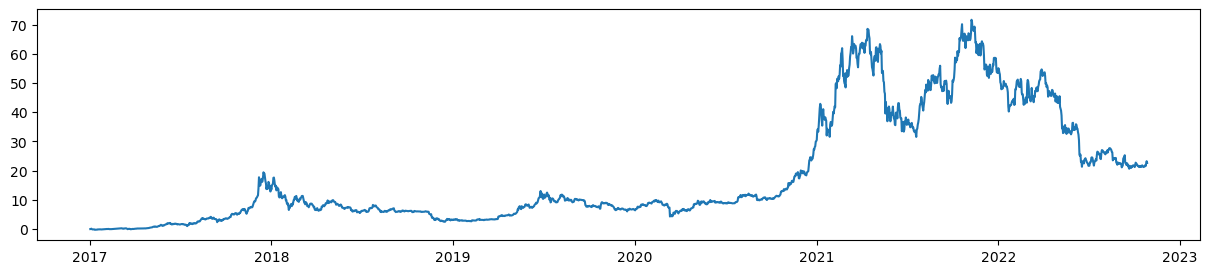

In [47]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 3))
plt.plot(df.index,df["Bench_C_Rets"].values)
plt.show()

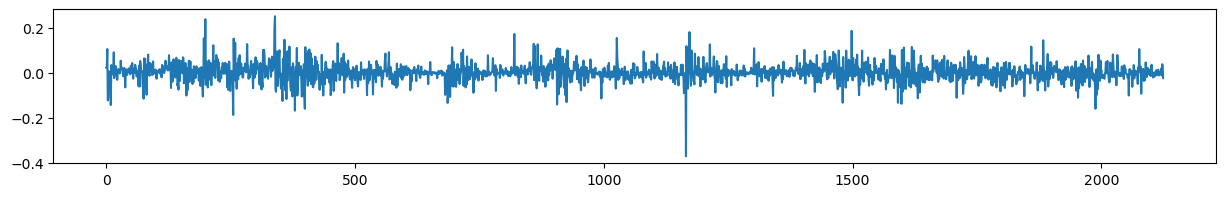

In [28]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Returns"].values)
plt.show()

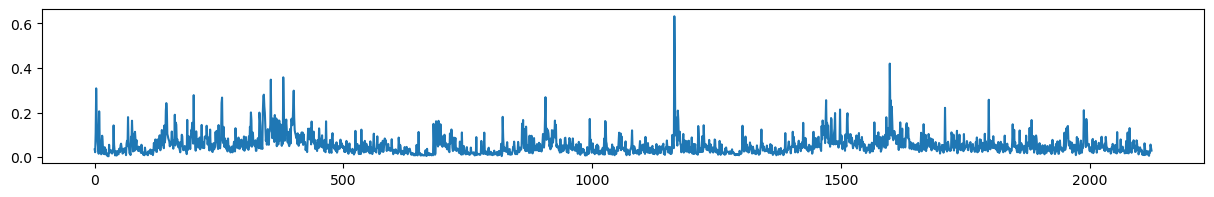

In [29]:
# Benchmark Range Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Range"].values)
plt.show()

### Feature Engineering - Feature Expansion

In [30]:
# Create a copy
df_fe = df.copy()

##### Indicators

In [31]:
# Add RSI
rsi = RSIIndicator(close=df_fe["Close"], window=14).rsi()
df_fe["RSI"] = rsi
df_fe["RSI_Ret"] = df_fe["RSI"] / df_fe["RSI"].shift(1)

In [32]:
# Add Moving Average
df_fe["MA_12"] = df_fe["Close"].rolling(window=12).mean()
df_fe["MA_21"] = df_fe["Close"].rolling(window=21).mean()

In [33]:
# Day of Week
df_fe["DOW"] = df_fe.index.dayofweek

In [34]:
# Rolling Cumulative Returns
df_fe["Roll_Rets"] = df_fe["Returns"].rolling(window=30).sum()

In [35]:
# Rolling Cumulative Range
df_fe["Avg_Range"] = df_fe["Range"].rolling(window=30).mean()

##### Time Intervals

In [36]:
# Add Time Intervals
t_steps = [1, 2]
t_features = ["Returns", "Range", "RSI_Ret"]
for ts in t_steps:
    for tf in t_features:
        df_fe[f"{tf}_T{ts}"] = df_fe[tf].shift(ts)

In [37]:
# Show DataFrame
df_fe.head(3)

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0.023464,0.034803,0.023314,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0.021620,0.022005,0.045999,NaN,NaN,...,NaN,1,NaN,NaN,0.023464,0.034803,NaN,NaN,NaN,NaN
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0.106233,0.110130,0.159122,NaN,NaN,...,NaN,2,NaN,NaN,0.021620,0.022005,NaN,0.023464,0.034803,NaN


### Feature Engineering - Feature Scaling

In [38]:
# Correct for Stationarity
df_fs = df_fe.copy()
df_fs[["Open", "High", "Low", "Volume"]] = df_fs[["Open", "High", "Low", "Volume"]].pct_change()
df_fs

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,NaN,NaN,NaN,1021.750000,NaN,0.023464,0.034803,0.023314,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,0.023015,0.012304,0.024980,1043.839966,-0.166604,0.021620,0.022005,0.045999,NaN,NaN,...,NaN,1,NaN,NaN,0.023464,0.034803,NaN,NaN,NaN,NaN
2017-01-04,0.022318,0.110471,0.022318,1154.729980,0.862881,0.106233,0.110130,0.159122,NaN,NaN,...,NaN,2,NaN,NaN,0.021620,0.022005,NaN,0.023464,0.034803,NaN
2017-01-05,0.107555,0.027324,-0.128287,1013.380005,0.479069,-0.122410,0.308302,0.018098,NaN,NaN,...,NaN,3,NaN,NaN,0.106233,0.110130,NaN,0.021620,0.022005,NaN
2017-01-06,-0.123183,-0.121140,-0.029078,902.200989,-0.310316,-0.109711,0.184249,-0.092307,NaN,NaN,...,NaN,4,NaN,NaN,-0.122410,0.308302,NaN,0.106233,0.110130,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-23,0.001844,0.020708,-0.000421,19567.007812,0.374080,0.018680,0.027319,21.849943,52.470317,1.125770,...,19417.484747,6,0.016827,0.027681,0.001863,0.006054,1.013388,0.006231,0.024848,1.045301
2022-10-24,0.018744,-0.002928,0.004294,19345.572266,0.364839,-0.011317,0.019931,21.590646,48.902095,0.931995,...,19404.246280,0,0.024198,0.027553,0.018680,0.027319,1.125770,0.001863,0.006054,1.013388
2022-10-25,-0.011386,0.038761,0.002870,20095.857422,0.581390,0.038783,0.056432,22.462557,59.060854,1.207737,...,19392.770740,1,0.070106,0.028653,-0.011317,0.019931,0.931995,0.018680,0.027319,1.125770


### Assess Data for ML Readiness

In [39]:
# Check for NaN
df_fs.dropna(inplace=True)
print(df_fs.isnull().values.any())

False


In [40]:
# Check for Inf values
dfobj = df_fs.isin([np.inf, -np.inf])
count = np.isinf(dfobj).values.sum()
count

0

In [41]:
# Check for non-numerical objects
df_fs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2096 entries, 2017-01-31 to 2022-10-27
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2096 non-null   float64
 1   High          2096 non-null   float64
 2   Low           2096 non-null   float64
 3   Close         2096 non-null   float64
 4   Volume        2096 non-null   float64
 5   Returns       2096 non-null   float64
 6   Range         2096 non-null   float64
 7   Bench_C_Rets  2096 non-null   float64
 8   RSI           2096 non-null   float64
 9   RSI_Ret       2096 non-null   float64
 10  MA_12         2096 non-null   float64
 11  MA_21         2096 non-null   float64
 12  DOW           2096 non-null   int64  
 13  Roll_Rets     2096 non-null   float64
 14  Avg_Range     2096 non-null   float64
 15  Returns_T1    2096 non-null   float64
 16  Range_T1      2096 non-null   float64
 17  RSI_Ret_T1    2096 non-null   float64
 18  Returns_T2

In [42]:
# Describe DataFrame
df_fs.describe()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
count,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,...,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000
mean,0.002326,0.002121,0.002341,17861.265073,0.034913,0.002315,0.053893,18.788856,52.710758,1.005326,...,17772.191404,2.998569,0.069161,0.053969,0.002327,0.053881,1.005380,0.002310,0.053863,1.005323
std,0.040798,0.035764,0.041110,16994.153166,0.287355,0.040804,0.044645,18.972009,14.448922,0.105031,...,16937.752847,1.999641,0.250522,0.024200,0.040800,0.044656,0.105001,0.040795,0.044668,0.104975
min,-0.365924,-0.263712,-0.364062,937.520020,-0.869188,-0.371695,0.004622,-0.044698,9.920239,0.453659,...,885.613522,0.000000,-0.844981,0.015818,-0.371695,0.003887,0.453659,-0.371695,0.003887,0.453659
25%,-0.015651,-0.012579,-0.012494,6455.865112,-0.124860,-0.015811,0.026270,6.045793,42.544848,0.953202,...,6489.531616,1.000000,-0.091080,0.036809,-0.015782,0.026249,0.953566,-0.015782,0.026235,0.953566
50%,0.001919,-0.000097,0.003050,9565.745117,-0.008248,0.001953,0.042460,9.289499,51.706727,1.005243,...,9464.842611,3.000000,0.041633,0.048745,0.001953,0.042460,1.005243,0.001937,0.042423,1.005221
75%,0.020277,0.015995,0.019142,28864.803711,0.146004,0.020239,0.065760,31.707269,62.433653,1.047929,...,28430.833380,5.000000,0.230315,0.065375,0.020239,0.065760,1.047929,0.020096,0.065760,1.047826
max,0.250461,0.245708,0.247892,67566.828125,5.439003,0.252472,0.631387,71.644966,94.302215,1.926078,...,63016.876488,6.000000,1.154731,0.138628,0.252472,0.631387,1.926078,0.252472,0.631387,1.926078


### Save Data

In [43]:
# Save DataFrame
df_fs.to_csv(f"data/{symbol}.csv")